## Loading the IMBD movie review dataset as the training dataset

In [ ]:
!pip install tensorflow
!pip install keras_bert

### Transform into embeddings 


In [26]:
# y_train = []
# x_train = []
# embeddings = extract_embeddings(pretrained_path, train_data[0:20000])
# for index in range(20000):
#     x_train.append(embeddings[index][0]) 
#     y_train.append(train_label[index])
# nowfile = open('drive/MyDrive/Sentiment/project/Dataset.txt', 'w')
# for i in range(20000):
#     nowfile.write(str(y_train[i]))
#     for j in range(len(x_train[i])):
#         nowfile.write(' ' + str(x_train[i][j]))
#     nowfile.write('\n')
# nowfile.close()

In [2]:
pretrained_path = './BERT-Tiny'
from keras_bert import extract_embeddings

### Loading Embeddings
Have been saved to the Dataset.txt

In [3]:
import numpy as np
def read_input_data(path):
    x = []
    y = []
    for line in open(path).readlines():
        items = line.strip().split(' ')
        tempX = []
        for i in range(1, len(items)): tempX.append(float(items[i]))
        x.append(tempX)
        y.append(float(items[0]))
    return np.array(x), np.array(y)

In [4]:
#training set 30000 embeddings
TrainingPath = "./Dataset.txt"
x_train, y_train = read_input_data(TrainingPath)
print(x_train.shape)
print(y_train)

(30000, 128)
[ 1.  1.  1. ... -1. -1.  1.]


## Training model

### Choosing rbf kernel

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)

param_dist = {'C': loguniform(1e-2, 1e2),
 'gamma': loguniform(1e-4, 1e-3),
 'kernel': ['rbf'],
 'class_weight':['balanced', None]}

n_iter_search = 5

model = RandomizedSearchCV(SVC(), param_distributions=param_dist, n_iter=n_iter_search)
model.fit(X_train[:20000],y_train[:20000])

print('Best score for training data:', model.best_score_,"\n") 
# View the best parameters for the model found using grid search
print('Best C:',model.best_estimator_.C,"\n") 
print('Best Kernel:',model.best_estimator_.kernel,"\n")
print('Best Gamma:',model.best_estimator_.gamma,"\n")

Best score for training data: 0.77295 

Best C: 19.170932541804394 

Best Kernel: rbf 

Best Gamma: 0.0005910786143286416 



Saving trained model

In [6]:
import joblib
joblib.dump(model, 'tiny-taskModel')

['tiny-taskModel']

## Using the model to predict YouTube review

In [13]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")
import yt_helper

In [16]:
import joblib
task_model = joblib.load('tiny-taskModel')

In [17]:
def yt_comment_preprocess(df, limit):
    processed_dataset = yt_helper.comment.preprocessing(df=df, emoji_to_word=True) 
    test_data = processed_dataset['regular_text']
    
    embeddings_test = extract_embeddings(pretrained_path, test_data)
    x_test = []
    for i in range(limit):
        x_test.append(embeddings_test[i][0])
        
    return x_test

In [18]:
def predict_result(youtubeID):
    SORT_BY_POPULAR = 1
    SORT_BY_RECENT = 0

    limit = 200 # set to None to download all comments
    sort = SORT_BY_POPULAR
    output = None  # do not write out files

    df = yt_helper.comment.fetch(youtubeID=youtubeID, limit=limit,
                                                language='en', sort=sort, output=output)

    x_test = yt_comment_preprocess(df, limit)
    y_pred = task_model.predict(x_test)
    positive_rate = (y_pred >= 0.5).sum() / y_pred.shape[0]
    nagative_rate = (y_pred < 0.5).sum() / y_pred.shape[0]
    return positive_rate, nagative_rate

In [20]:
youtubeID = 'OscqgBj1HCw'
predict_result(youtubeID)

Downloaded 200 comment(s)
[9.02 seconds] Done!


C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(0.195, 0.805)

## Evaluating the performance of choosen model

In [21]:
import pandas as pd
df_test = pd.read_csv('output.csv')
df_test = df_test[df_test['label'] != 0]
df_test['label'] = df_test['label'].apply(lambda x: -1 if x < 0 else x)

test_data = df_test['comment']
y_test = df_test['label']

In [22]:
embeddings_test = extract_embeddings(pretrained_path, test_data)

x_test = []
for i in range(len(y_test)):
    x_test.append(embeddings_test[i][0])

print(len(x_test))
print(len(embeddings_test))

200
200


In [11]:
from sklearn import metrics
import joblib
loaded_model = joblib.load('tiny-taskModel')

X_test = scaler.transform(x_test)
X_test = np.array(X_test)
y_pred = loaded_model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.47      0.44      0.46        54
           1       0.80      0.82      0.81       146

    accuracy                           0.71       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.71      0.71      0.71       200



In [23]:
positive_rate = (y_pred >= 0.5).sum() / y_pred.shape[0]
nagative_rate = (y_pred < 0.5).sum() / y_pred.shape[0]
print('positive_rate:', positive_rate,', nagative_rate:', nagative_rate)

positive_rate: 0.745 , nagative_rate: 0.255


In [24]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("roc_auc:", roc_auc)

roc_auc: 0.6297564687975648


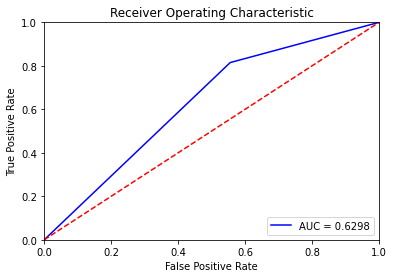

In [25]:
import matplotlib.pyplot as plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()